# Computer Vision project 3 - final report

Team members: Joanna Działo 148260, Wojciech Majewski 148253

Selected problem: Colourization -
We will attempt to accurately colour greyscale images using Neural Networks.

Dataset: https://paperswithcode.com/dataset/spair-71k

### Problem description

The goal of this project is to accurately predict the original colors of a greyscale image. Our dataset contains colored images, from which we generate their greyscale counterparts. The greyscale images become the 'X' training, validation and test dataset, while the original coloured images are used to create 'y' datasets.

### Dataset description

The dataset consists of 18 categories with 100 photos each.

#### Downloading dataset

In [ ]:
import os
import numpy as np
import cv2
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = cv2.imshow

In [ ]:
!wget -O SPair-71k.tar.gz http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

--2023-01-26 03:13:53--  http://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
Resolving cvlab.postech.ac.kr (cvlab.postech.ac.kr)... 141.223.85.126
Connecting to cvlab.postech.ac.kr (cvlab.postech.ac.kr)|141.223.85.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226961117 (216M) [application/x-gzip]
Saving to: ‘SPair-71k.tar.gz’

SPair-71k.tar.gz    100%[===================>] 216.45M  7.76MB/s    in 28s     

2023-01-26 03:14:21 (7.84 MB/s) - ‘SPair-71k.tar.gz’ saved [226961117/226961117]



In [ ]:
!mkdir dataset

In [ ]:
!tar -xzf SPair-71k.tar.gz -C dataset

In [ ]:
!mv dataset/SPair-71k/JPEGImages /content/

!rm -rf SPair-71k.tar.gz
!rm -rf dataset

In [ ]:
!mv JPEGImages dataset

#### Dataset categories names and sizes

In [ ]:
categories = os.listdir("dataset")
print(categories)

['bicycle', 'tvmonitor', 'person', 'chair', 'dog', 'boat', 'bottle', 'aeroplane', 'train', 'motorbike', 'pottedplant', 'cow', 'cat', 'horse', 'bus', 'car', 'bird', 'sheep']


In [ ]:
sizes = [len([os.path.join(os.path.join('dataset', cat), img) for img in os.listdir(os.path.join('dataset', cat))]) for cat in categories]
print(sizes)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


#### Dataset image examples

In [ ]:
def load_images(path, category, limit = None):
    category_path = os.path.join(path, category)
    images_paths = [os.path.join(category_path,img) for img in os.listdir(category_path)]
    images = [cv2.resize(cv2.imread(f, 1), (256, 256)) for f in images_paths]
    if limit == None:
        return images
    else:
        limit_norm = min(limit, len(images))
        return images[:limit_norm]
        
def create_dataset(path, categories = None, limit = None):
    if categories == None:
        categories = os.listdir(path)
    y = []
    for category in categories:
        images = load_images(path, category, limit)
        y.extend(images)
    return y

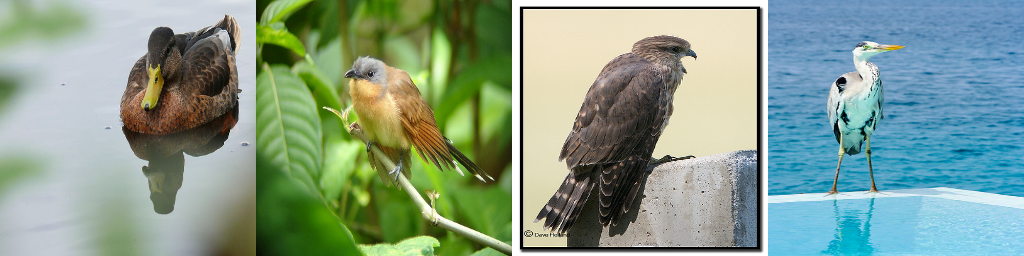

In [ ]:
images = load_images("dataset", "bird")
imshow(np.concatenate((images[:4]), 1))

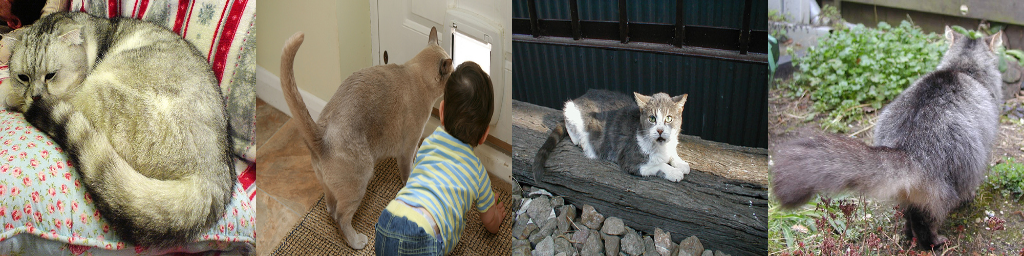

In [ ]:
images = load_images("dataset", "cat")
imshow(np.concatenate((images[:4]), 1))

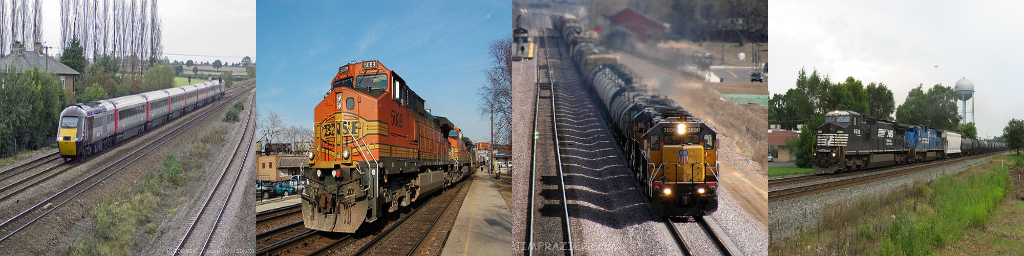

In [ ]:
images = load_images("dataset", "train")
imshow(np.concatenate((images[:4]), 1))

#### Notably, there are some 'black sheep' in our dataset:

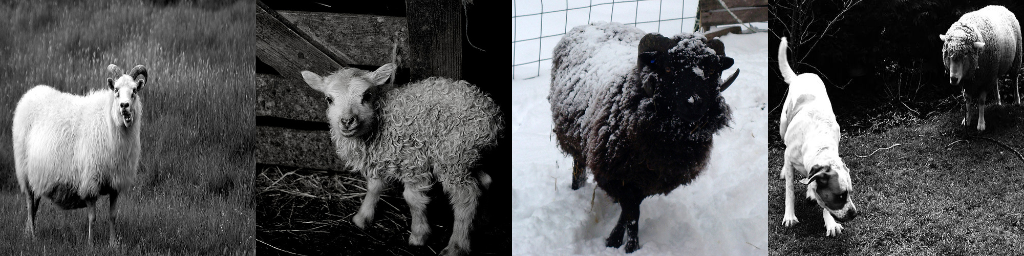

In [ ]:
images = load_images("dataset", "sheep")
imshow(np.concatenate((images[95], images[12], images[22], images[66]), 1))

### Imports

In [ ]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from math import floor
from tensorflow.keras.utils import img_to_array
from model_profiler import model_profiler

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Dividing data into train, validation and test datasets

In [ ]:
def create_split_dataset_3(path, categories = None, training_split = 0.8, test_split = 0.1, size = 256):
    if categories == None:
        categories = os.listdir(path)
    
    X_train = []
    y_train = []
    X_validation = []
    y_validation = []
    X_test = []
    y_test = []


    for category in categories:

        color_images = []
        gray_images = []
        category_path = os.path.join(path, category)

        images_paths = [os.path.join(category_path,img) for img in os.listdir(category_path)]

        i = 0
        for image_path in images_paths:
            image = cv2.cvtColor(cv2.cvtColor(cv2.imread(image_path, 1), cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
            image = cv2.resize(image, (size, size), cv2.INTER_CUBIC)
            image = image.astype('float32')/255.0
            gray_images.append(img_to_array(image))
            image = cv2.cvtColor(cv2.imread(image_path, 1), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (size, size), cv2.INTER_CUBIC)
            image = image.astype('float32')/255.0
            color_images.append(img_to_array(image))
        
        y_train += color_images[:floor(len(color_images) * training_split)]
        X_train += gray_images[:floor(len(color_images) * training_split)]
        y_validation += color_images[floor(len(color_images) * training_split) : floor(len(color_images) * (test_split + training_split))]
        X_validation += gray_images[floor(len(color_images) * training_split) : floor(len(color_images) * (test_split + training_split))]
        y_test += color_images[floor(len(color_images) * (test_split + training_split)):]
        X_test += gray_images[floor(len(color_images) * (test_split + training_split)):]


    X_train = np.reshape(X_train, (len(X_train), size, size, 3))
    y_train = np.reshape(y_train, (len(y_train), size, size, 3))
    X_validation = np.reshape(X_validation, (len(X_validation), size, size, 3))
    y_validation = np.reshape(y_validation, (len(y_validation), size, size, 3))
    X_test = np.reshape(X_test, (len(X_test), size, size, 3))
    y_test = np.reshape(y_test, (len(y_test), size, size, 3))

    print(X_train.shape)
    print(y_train.shape)
    print(X_validation.shape)
    print(y_validation.shape)
    print(X_test.shape)
    print(y_test.shape)

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [ ]:
X_train, y_train, X_validation, y_validation, X_test, y_test = create_split_dataset_3('dataset', size = 200)

(1440, 200, 200, 3)
(1440, 200, 200, 3)
(180, 200, 200, 3)
(180, 200, 200, 3)
(180, 200, 200, 3)
(180, 200, 200, 3)


### Model description

In [ ]:
encoder = Sequential([
      InputLayer(input_shape=(200, 200, 3),name="Input_layer"),
      BatchNormalization(),
      Conv2D(64,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_01"),
      BatchNormalization(),
      MaxPool2D(),
      Conv2D(128,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_02"),
      BatchNormalization(),
      MaxPool2D(),
      Conv2D(256,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_03"),
      BatchNormalization(),
      MaxPool2D(),
      Conv2D(512,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_04"),
      BatchNormalization(),
      MaxPool2D(),
  ])

decoder = Sequential([
      InputLayer(input_shape=(encoder.output_shape[-3:]),name='decoder_input'),
      BatchNormalization(),
      Conv2DTranspose(256,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_initializer='lecun_normal',name='ConvT_01'),
      BatchNormalization(),
      Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='lecun_normal',name='ConvT_02'),
      BatchNormalization(),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='lecun_normal',name='ConvT_03'),
      BatchNormalization(),
      Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='glorot_normal',name='ConvT_04'),
      Reshape([200, 200, 3])
  ])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.MeanSquaredError()]
    )

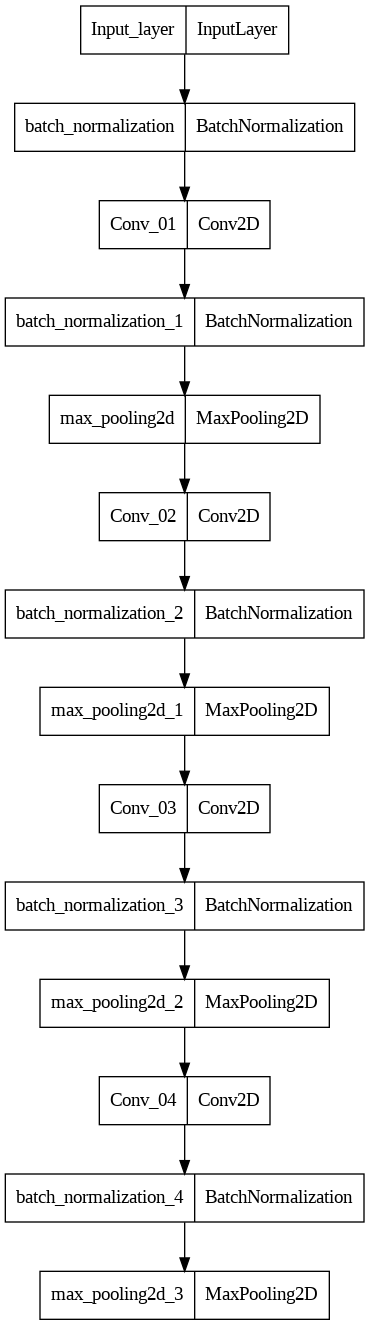

In [ ]:
tf.keras.utils.plot_model(encoder)

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 200, 200, 3)      12        
 ormalization)                                                   
                                                                 
 Conv_01 (Conv2D)            (None, 200, 200, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 200, 200, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 Conv_02 (Conv2D)            (None, 100, 100, 128)     73856     
                                                        

Through repeated use of Convolution, Batch Normalization and Max Pooling, the encoder is able to boil each image down to specific patterns, which can be interpeted, and coloured. 
The parameters through each layer are listed above.

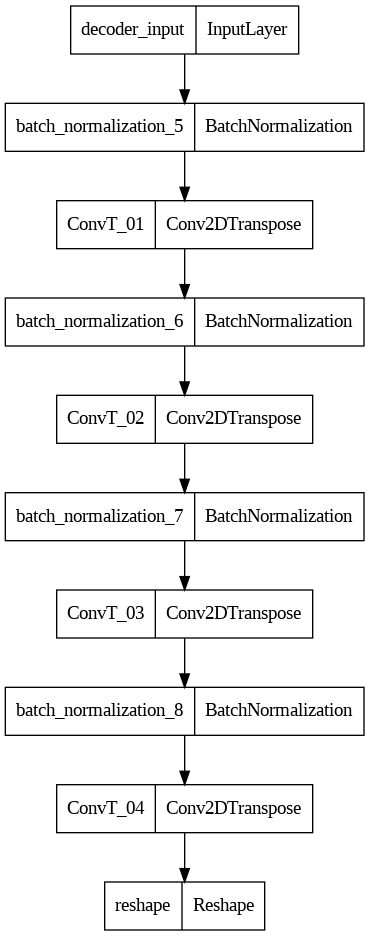

In [ ]:
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 12, 12, 512)      2048      
 hNormalization)                                                 
                                                                 
 ConvT_01 (Conv2DTranspose)  (None, 25, 25, 256)       1179904   
                                                                 
 batch_normalization_6 (Batc  (None, 25, 25, 256)      1024      
 hNormalization)                                                 
                                                                 
 ConvT_02 (Conv2DTranspose)  (None, 50, 50, 128)       295040    
                                                                 
 batch_normalization_7 (Batc  (None, 50, 50, 128)      512       
 hNormalization)                                                 
                                                      

The Batch Normalization and Convolution Transposer layers can propagate the selected features from encoder back to the full scale image, but with added color information.
The parameters through each layer are listed above.

In [ ]:
Batch_size = 32
profile = model_profiler(autoencoder, Batch_size)

print(profile)

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0     | BFLOPs  |
| GPU Memory Requirement           | 0.026   | GB      |
| Model Parameters                 | 3.1091  | Million |
| Memory Required by Model Weights | 11.8604 | MB      |


Here are the parameters and memory size of thewhole autoencoder model.

### Training the model

Training is done through 50 epochs with batches of 32 images from the training set, resulting in 45 steps per epoch.

In [ ]:
history = autoencoder.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_validation, y_validation)
)

Epoch 1/50
45/45 [==============================] - 664s 15s/step - loss: 0.0362 - accuracy: 0.4009 - mean_squared_error: 0.0730 - val_loss: 0.0355 - val_accuracy: 0.3492 - val_mean_squared_error: 0.0710
Epoch 2/50
45/45 [==============================] - 673s 15s/step - loss: 0.0137 - accuracy: 0.4146 - mean_squared_error: 0.0274 - val_loss: 0.0238 - val_accuracy: 0.3743 - val_mean_squared_error: 0.0475
Epoch 3/50
45/45 [==============================] - 660s 15s/step - loss: 0.0112 - accuracy: 0.4303 - mean_squared_error: 0.0224 - val_loss: 0.0231 - val_accuracy: 0.4409 - val_mean_squared_error: 0.0462
Epoch 4/50
45/45 [==============================] - 672s 15s/step - loss: 0.0106 - accuracy: 0.4344 - mean_squared_error: 0.0213 - val_loss: 0.0188 - val_accuracy: 0.4094 - val_mean_squared_error: 0.0376
Epoch 5/50
45/45 [==============================] - 670s 15s/step - loss: 0.0107 - accuracy: 0.4401 - mean_squared_error: 0.0213 - val_loss: 0.0171 - val_accuracy: 0.3924 - val_mean_sq

### Training plots

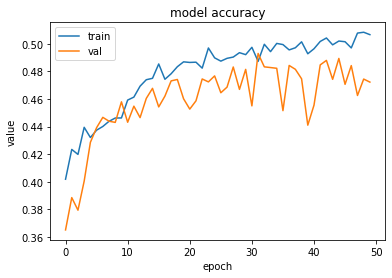

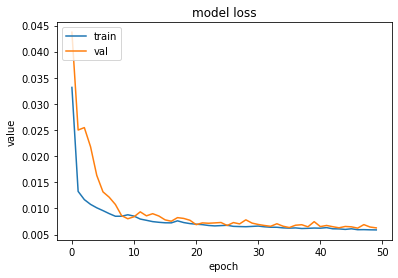

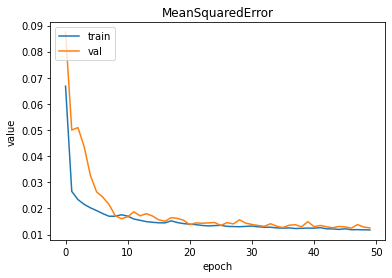

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MeanSquaredError')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = autoencoder.evaluate(X_test, y_test, batch_size=32)

6/6 [==============================] - 0s 74ms/step - loss: 0.0060 - accuracy: 0.4946 - mean_squared_error: 0.0120


In [ ]:
print(f'loss: {results[0]} - accuracy: {results[1]} - mean_squared_error: {results[2]}') 

loss: 0.005984642077237368 - accuracy: 0.49457332491874695 - mean_squared_error: 0.01196928508579731


### Description of metrics, loss and evaluation

The metrics used are accuracy and mean squared error. 
Accuracy calculates how often the predictions were correct.
Mean squared error is calculated on errors between each pixel of redicted image versus the original coloured one.
The loss function used is Huber loss, which was selected based on our research in Tuning.ipynb.
Huber loss is a combination of mean square error and absolute value function. For our purpouses, the Huber loss function proved to be better than MSE.<br>
 Evaluation has returned the loss function to be 0.0060, accuracy as 0.4946 and mean_squared_error as 0.0120

### Results

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


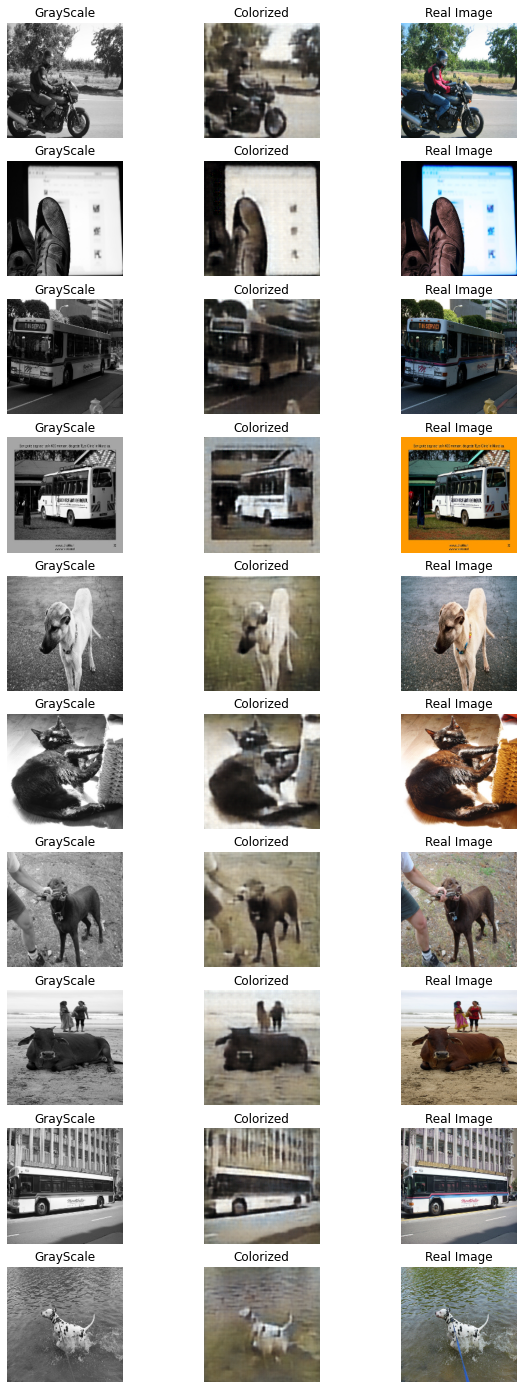

In [ ]:
plt.figure(figsize=(10,25))

for i in range(1,30,3):
    rand_idx = np.random.randint(len(y_test))
    color_img = y_test[rand_idx]
    gray_img = X_test[rand_idx]
    colorized = autoencoder.predict(gray_img[np.newaxis,...])[0]

    plt.subplot(10,3,i)
    plt.title("GrayScale")
    plt.imshow(gray_img)
    plt.axis('off')
    
    plt.subplot(10,3,i+1)
    plt.title("Colorized")
    plt.imshow(colorized)
    plt.axis('off')

    plt.subplot(10,3,i+2)
    plt.title("Real Image")
    plt.imshow(color_img)
    plt.axis('off')

### Training and inference time

- Training time is 335ms per step, around 15 seconds per epoch, 12 minutes 45 seconds for all 50 epochs.
- Inference time for 10 randomly chosen images from the test dataset is 5.048 seconds.

### Libraries and tools used



- Tensorflow keras,
- Matplotlib,
- Skimage,
- CV2
- Model profiler

### Bibliography

- Main dataset origin: http://cvlab.postech.ac.kr/research/SPair-71k/

- Article about image colorization in keras, used sparingly but with helful insights:
https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d
- Autoencoder info https://rukshanpramoditha.medium.com/an-introduction-to-autoencoders-in-deep-learning-ab5a5861f81e
-Additional insight: https://www.kaggle.com/code/aya25hassan/image-coloring-using-autoencoders/notebook